In [ ]:
import pandas as pd
df = pd.read_csv("/content/All_epochs_combined_e1 (1).csv")

In [ ]:
columns_to_keep = ['Decision'] + [col for col in df.columns if col.startswith('En_')]
df_filtered = df[columns_to_keep]


In [ ]:
print("Filtered columns:", df_filtered.columns.tolist())

Filtered columns: ['Decision', 'En_Fp1', 'En_Fp2', 'En_F3', 'En_F4', 'En_C3', 'En_C4', 'En_P3', 'En_P4', 'En_O1', 'En_O2', 'En_F7', 'En_F8', 'En_P7', 'En_P8', 'En_Fz', 'En_Cz', 'En_Pz', 'En_IO', 'En_FC2', 'En_CP1', 'En_CP2', 'En_FC5', 'En_FC6', 'En_CP5', 'En_CP6', 'En_FCz']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import StepLR

In [ ]:
df_filtered["Decision"] = df_filtered["Decision"].map({"stay": 0, "leave": 1})

<ipython-input-37-ca4aa440d993>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Decision"] = df_filtered["Decision"].map({"stay": 0, "leave": 1})


In [ ]:
entropy_cols = [col for col in df.columns if col.startswith("En")]
X = df_filtered[entropy_cols].values
y = df_filtered["Decision"].values

# Handle imbalance using class weights

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

# Define neural network

In [ ]:
class BetterNN(nn.Module):
    def __init__(self, input_dim):
        super(BetterNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.4),

            nn.Linear(64, 32),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.3),

            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.network(x)
model = BetterNN(X_train.shape[1])

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

In [ ]:
epochs = 1000
for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

In [ ]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_preds_cls = torch.argmax(test_preds, axis=1)
    print(classification_report(y_test, test_preds_cls.numpy()))
    test_acc = accuracy_score(y_test, test_preds_cls.numpy())
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       674
           1       0.34      0.30      0.32       166

    accuracy                           0.75       840
   macro avg       0.59      0.58      0.58       840
weighted avg       0.74      0.75      0.74       840

Test Accuracy: 74.64%


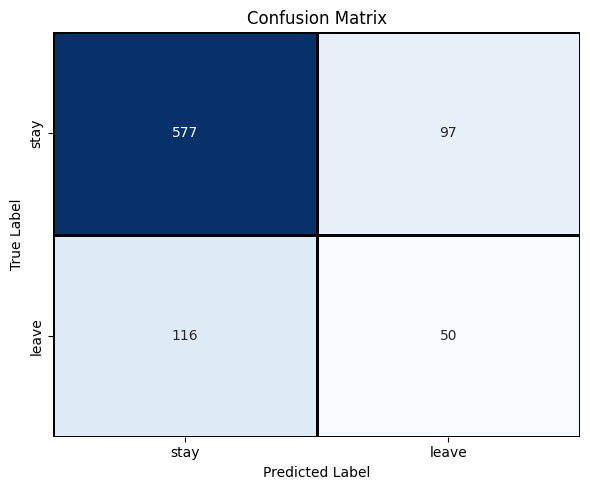

In [ ]:
cm = confusion_matrix(y_test, test_preds_cls.numpy())
class_names = ['stay', 'leave']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, linewidths=1, linecolor='black')

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

In [ ]:
import pandas as pd
df = pd.read_csv("/content/All_epochs_combined (1).csv")

In [ ]:
columns_to_keep = ['Decision'] + [col for col in df.columns if col.startswith('En_')]
df_filtered = df[columns_to_keep]


In [ ]:
entropy_cols = [col for col in df.columns if col.startswith("En")]
X = df_filtered[entropy_cols].values
y = df_filtered["Decision"].values

In [ ]:
df_filtered["Decision"] = df_filtered["Decision"].map({"stay": 0, "leave": 1})

<ipython-input-75-ca4aa440d993>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Decision"] = df_filtered["Decision"].map({"stay": 0, "leave": 1})


In [ ]:
entropy_cols = [col for col in df.columns if col.startswith("En")]
X = df_filtered[entropy_cols].values
y = df_filtered["Decision"].values

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [ ]:
model = BetterNN(X_train.shape[1])

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

In [ ]:
epochs = 1000
for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

In [ ]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_preds_cls = torch.argmax(test_preds, axis=1)
    print(classification_report(y_test, test_preds_cls.numpy()))
    test_acc = accuracy_score(y_test, test_preds_cls.numpy())
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1292
           1       0.25      0.35      0.29       266

    accuracy                           0.72      1558
   macro avg       0.55      0.57      0.56      1558
weighted avg       0.75      0.72      0.73      1558

Test Accuracy: 71.50%


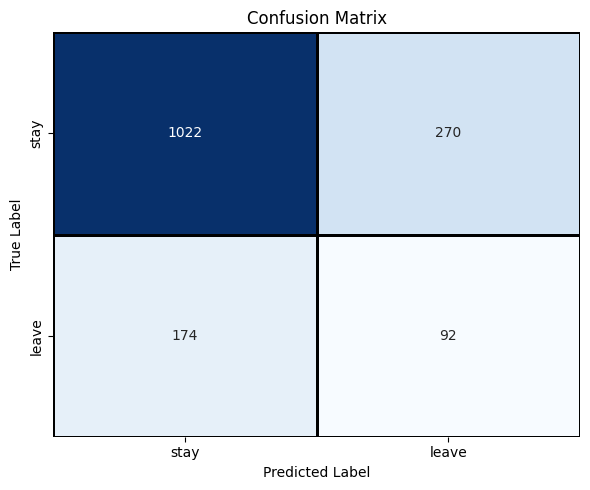

In [ ]:
cm = confusion_matrix(y_test, test_preds_cls.numpy())
class_names = ['stay', 'leave']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, linewidths=1, linecolor='black')

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig("confusion_matrix_combined.png", dpi=300)
plt.show()

In [ ]:
import pandas as pd
df = pd.read_csv("/content/All_epochs_combined_e2 (1).csv")

In [ ]:
columns_to_keep = ['Decision'] + [col for col in df.columns if col.startswith('En_')]
df_filtered = df[columns_to_keep]


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [ ]:
model = BetterNN(X_train.shape[1])

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

In [ ]:
epochs = 1000
for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

In [ ]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_preds_cls = torch.argmax(test_preds, axis=1)
    print(classification_report(y_test, test_preds_cls.numpy()))
    test_acc = accuracy_score(y_test, test_preds_cls.numpy())
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

              precision    recall  f1-score   support

           0       0.86      0.74      0.79      1292
           1       0.24      0.41      0.31       266

    accuracy                           0.68      1558
   macro avg       0.55      0.57      0.55      1558
weighted avg       0.75      0.68      0.71      1558

Test Accuracy: 68.04%


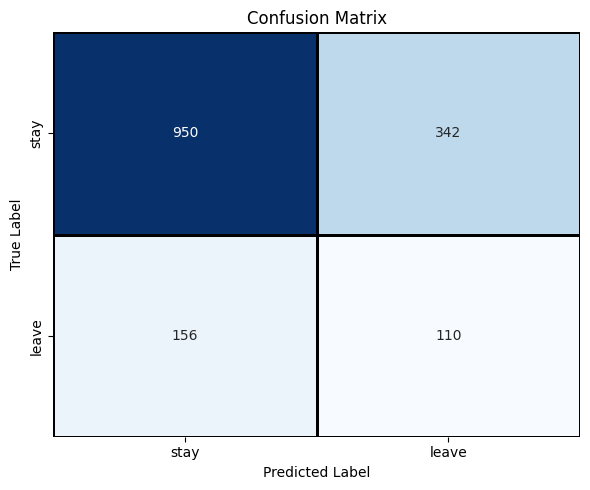

In [ ]:
cm = confusion_matrix(y_test, test_preds_cls.numpy())
class_names = ['stay', 'leave']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, linewidths=1, linecolor='black')

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig("confusion_matrix_combined.png", dpi=300)
plt.show()